In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow import keras
import matplotlib.pyplot as plot
import numpy as np
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


In [2]:
Images = np.load('./dataset/Image_120.npy') #converting the list of images to numpy array.
Labels = np.load('./dataset/Label_120.npy')

In [3]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (720, 128, 128, 3)
Shape of Labels: (720,)


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
len(Images)

720

In [6]:
# Images = (Images / 127.5) -1

In [7]:
Images.dtype

dtype('uint8')

In [8]:
Images = Images.astype('float32')
Images.dtype, Labels.dtype

(dtype('float32'), dtype('int64'))

In [9]:
names = {0: 'Tomato_H', 1: 'Tomato_D01', 2: 'Tomato_D04', 3: 'Tomato_D05', 
             4: 'Tomato_D07', 5: 'Tomato_D08', 6: 'Tomato_D09', 7: 'Tomato_P03', 
             8: 'Tomato_P05'}

In [10]:
X_train, X_test ,y_train, y_test = train_test_split(Images, Labels,test_size=0.3333, stratify=Labels, random_state=1, shuffle=True)

In [11]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
np.bincount(y_train),np.bincount(y_test)

(480, 128, 128, 3) (240, 128, 128, 3) (480,) (240,)


(array([80, 80, 80, 80, 80, 80]), array([40, 40, 40, 40, 40, 40]))

In [12]:
y_test[0:20]

array([3, 4, 4, 0, 3, 0, 0, 5, 4, 4, 1, 0, 1, 0, 3, 2, 3, 5, 2, 2])

In [13]:
X_train[0:1].shape

(1, 128, 128, 3)

In [14]:
IMG_SHAPE = X_train[0].shape

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,   
                                            weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
test_batch = tf.convert_to_tensor(X_train[0:8])
test_batch

<tf.Tensor 'Const:0' shape=(8, 128, 128, 3) dtype=float32>

In [16]:
feature_batch = base_model(test_batch)
print(feature_batch.shape)

(8, 4, 4, 1280)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [20]:
fc_1 = keras.layers.Dense(640, activation='relu')
fc_1_batch = fc_1(feature_batch_average)
print(fc_1_batch.shape)

(8, 640)


In [21]:
prediction_layer = keras.layers.Dense(6, activation='softmax')
prediction_batch = prediction_layer(fc_1_batch)
print(prediction_batch.shape)

(8, 6)


In [22]:
model = tf.keras.Sequential([
  base_model
])

In [23]:
import keras.backend as K

In [24]:
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

In [25]:
model.add(global_average_layer)
model.add(fc_1)
model.add(prediction_layer)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
# class_weights

In [28]:
# class_weight = {}

# for i in range(9):
#     class_weight[i] = class_weights[i]
    
# class_weight

In [29]:
# class_weight = [np.sqrt(np.sqrt(i)) for i in class_weights]
# class_weight

In [30]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, shuffle=True, random_state=1 )

In [31]:
y_val.shape, np.bincount(y_val), y_val.dtype, X_train_1.dtype

((240,), array([40, 40, 40, 40, 40, 40]), dtype('int64'), dtype('float32'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3846      
Total params: 3,081,670
Trainable params: 823,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 640) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(640,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(640, 6) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(6,) dtype=float32>]

In [34]:
# trained = model.fit(X_train_1, y_train_1, epochs=100, batch_size=32, validation_data=(X_val,y_val), class_weight = class_weight)
trained = model.fit(X_train_1, y_train_1, epochs=10, batch_size=2, validation_data=(X_val,y_val))

Train on 240 samples, validate on 240 samples
Epoch 1/10
240/240 [==============================] - 6s 25ms/sample - loss: 0.7370 - acc: 0.7917 - val_loss: 2.8618 - val_acc: 0.1667
Epoch 2/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.3694 - acc: 0.8750 - val_loss: 3.3715 - val_acc: 0.1667
Epoch 3/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.1565 - acc: 0.9667 - val_loss: 3.2956 - val_acc: 0.1667
Epoch 4/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.1087 - acc: 0.9833 - val_loss: 3.5433 - val_acc: 0.1667
Epoch 5/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.0527 - acc: 0.9917 - val_loss: 3.7044 - val_acc: 0.1667
Epoch 6/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.0683 - acc: 1.0000 - val_loss: 3.6172 - val_acc: 0.1667
Epoch 7/10
240/240 [==============================] - 2s 9ms/sample - loss: 0.0475 - acc: 1.0000 - val_loss: 3.4674 - val_acc: 0.1667
Epoch 8/10
240/

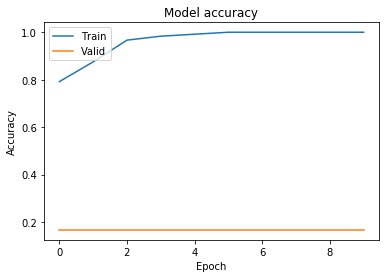

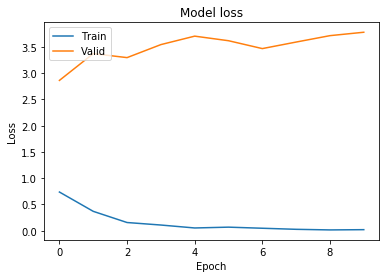

In [35]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Valid'], loc='upper left')
plot.show()

In [36]:
# test_images,test_labels = get_images('./test/')
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)
model.evaluate(X_test,y_test, verbose=1, batch_size=2)

240/240 [==============================] - 1s 4ms/sample - loss: 3.7786 - acc: 0.1667


[3.7786096503337223, 0.16666667]

In [37]:
# model.save('90per_2root.h5')

In [38]:
Images = np.load('./dataset/Image_1.npy') #converting the list of images to numpy array.
Labels = np.load('./dataset/Label_1.npy')

In [39]:
train_X, test_X, train_y, test_y = train_test_split(Images, Labels, test_size=0.2, stratify=Labels, shuffle=True, random_state=1)

In [40]:
model.evaluate(test_X, test_y, verbose=1, batch_size=2)

3413/3413 [==============================] - 13s 4ms/sample - loss: nan - acc: 0.0457


[nan, 0.045707587]